# Part I: Bag of Words

In [ ]:
#adapted from:
#https://github.com/sahilee26/IMDB-Movie-Reviews-Sentiment-Analysis/blob/master/Bag-of-words-random-forest.ipynb
#https://github.com/shiaoligreen/practical-data-science/tree/master/Bag%20of%20Words%20Meets%20Bags%20of%20Popcorn

# Load packages

#Generic tools
import re
import numpy as np
import os

#Data pre-preprocessing
import pandas as pd
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords as nltkstopwords
import nltk.data

#Data split and featurization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#Random forest classifier and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

#Random forest visualization
import graphviz
from sklearn.tree import export_graphviz

#Multilayer Perceptron classifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification





In [ ]:
# Load data
train = pd.read_csv("data/labeledTrainData.tsv",
                    header=0, delimiter="\t",
                    quoting=3)

test = pd.read_csv("data/testData.tsv",
                   header=0, delimiter="\t",
                   quoting=3 )

unlabeled_train = pd.read_csv("data/unlabeledTrainData.tsv", header=0,
                              delimiter="\t", quoting=3 )

# Split data to train and test partitions
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['sentiment']),
                                                    train.sentiment, test_size=0.2)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [ ]:
# Download text datasets, including stop words
nltk.download('stopwords') #Notebook root update

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
train.head()


,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [ ]:
from nltk.corpus import stopwords as nltkstopwords
print(nltkstopwords.words('english'))
#print(nltkstopwords.words('german'))
#print(nltkstopwords.words('chinese'))
#print(nltkstopwords.words.__dir__)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def review_to_words(review, string=True, remove_stopwords=False):
    '''
    Function to convert a document to a sequence of words,
    optionally removing stop words.
    Returns a list of words.
    '''
    # Remove HTML
    review_text = BeautifulSoup(review).get_text()

    # Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)

    # Convert words to lower case and split them
    words = review_text.lower().split()

    # Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(nltkstopwords.words("english"))
        words = [w for w in words if not w in stops]
    if string:
        return " ".join(words)
    else:
        return words

In [ ]:
# Can you select a single review (any random review) from the training data and pass it to review_to_words()?  What is the output?
# your code here
# get a single review from X_train
# print the review
# pass it as an argument to review_to_words()
# print the output

# select a single review
review = X_train.review[0]

# print the review
print(review)

# pass it to review_to_words()
words = review_to_words(review)

# print the output
print(words)


"Who would think Andy Griffith's \"Helen Crump\" (Aneta Corsaut) had a Steve McQueen movie in her past? But that is only one of several weird and wonderful things about the ultimate 1950s teenagers-battle-creatures movie, which might best be described as Rebel Without A Cause meets God Knows What From Outer Space. The Rebel is Steven McQueen (who would shortly decide that \"Steve\" sounded less prissy), a good boy with just enough wild to be interesting; the very wholesome yet understanding girlfriend is the aforementioned Aneta Corsaut. It was bad enough when their date was disrupted by teenage hot-rodders, but they are considerably more nonplussed when they encounter a gelatinous, man-eating What Is It that rides down to earth on its own hotrod meteor--and begins gobbling up townfolk right and left. But will the grown ups believe them? Of course not, what do they know, they're just kids!<br /><br />The movie is teeny bopper at its teeny bopping best. The actors take the rather preten

In [ ]:
def review_to_bigrams(review, remove_stopwords=False, add_startend_tokens=True):
    '''
    Function to convert a document to a sequence of word bigrams,
    optionally removing stop words.
    Returns a list of bigrams.
    '''
    #E.g., ["I", "liked", "this" ,"movie"] -> ["I liked", "liked this", "this movie"]
    #your code here

    # Remove HTML
    review_text = BeautifulSoup(review).get_text()

    # Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)

    # Convert words to lower case and split them
    words = review_text.lower().split()

    # Optionally add START and END tokens (True by default)
    if add_startend_tokens:
        words = ["START"] + words + ["END"]

    # Optionally remove stop words (False by default)
    if remove_stopwords:
        stops = set(nltkstopwords.words("english"))
        words = [w for w in words if not w in stops]

    # Generate bigrams
    bigrams = []
    for i in range(len(words)-1):
        bigrams.append(words[i] + " " + words[i+1])

    return bigrams

#print(review_to_bigrams(["I", "liked", "this", "movie"]))
my_bigrams =review_to_bigrams("I liked this movie")
print(my_bigrams)

['START i', 'i liked', 'liked this', 'this movie', 'movie END']


In [ ]:
# Get list of reviews
clean_train_reviews = [review_to_words(X_train["review"][i], remove_stopwords=True) for i in range(len(X_train))]
clean_test_reviews = [review_to_words(X_test["review"][i], remove_stopwords=True) for i in range(len(X_test))]

print(clean_train_reviews[0])

<ipython-input-6-5a0c99d70e9e>:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(review).get_text()


would think andy griffith helen crump aneta corsaut steve mcqueen movie past one several weird wonderful things ultimate teenagers battle creatures movie might best described rebel without cause meets god knows outer space rebel steven mcqueen would shortly decide steve sounded less prissy good boy enough wild interesting wholesome yet understanding girlfriend aforementioned aneta corsaut bad enough date disrupted teenage hot rodders considerably nonplussed encounter gelatinous man eating rides earth hotrod meteor begins gobbling townfolk right left grown ups believe course know kids movie teeny bopper teeny bopping best actors take rather pretentious script seriously many soulful look eyes adult supporting cast probably says kids third sentence real pleasure film creature well imagined well executed often manages generate surprising degree suspense although clearly cheap side check miniature sets guys blob actually fairly well made film catchy little theme song thrown good measure plu

In [ ]:
# Get lists of reviews using the bigram function instead of the review_to_words function

clean_train_bigram_reviews = [review_to_bigrams(X_train["review"][i]) for i in range(len(X_train))]
clean_test_bigram_reviews = [review_to_bigrams(X_test["review"][i]) for i in range(len(X_test))]

print(clean_train_bigram_reviews[0])

<ipython-input-8-853873343806>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(review).get_text()


['START who', 'who would', 'would think', 'think andy', 'andy griffith', 'griffith s', 's helen', 'helen crump', 'crump aneta', 'aneta corsaut', 'corsaut had', 'had a', 'a steve', 'steve mcqueen', 'mcqueen movie', 'movie in', 'in her', 'her past', 'past but', 'but that', 'that is', 'is only', 'only one', 'one of', 'of several', 'several weird', 'weird and', 'and wonderful', 'wonderful things', 'things about', 'about the', 'the ultimate', 'ultimate s', 's teenagers', 'teenagers battle', 'battle creatures', 'creatures movie', 'movie which', 'which might', 'might best', 'best be', 'be described', 'described as', 'as rebel', 'rebel without', 'without a', 'a cause', 'cause meets', 'meets god', 'god knows', 'knows what', 'what from', 'from outer', 'outer space', 'space the', 'the rebel', 'rebel is', 'is steven', 'steven mcqueen', 'mcqueen who', 'who would', 'would shortly', 'shortly decide', 'decide that', 'that steve', 'steve sounded', 'sounded less', 'less prissy', 'prissy a', 'a good', 'g

In [ ]:
# Initialize a bag of words
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000) #vocabulary size defined here, sorted by frequency - e.g., 5k most common terms.  How does model performance change if you increase/decrease this value?

# Fit transform the data
train_feat = vectorizer.fit_transform(clean_train_reviews).toarray()
test_feat = vectorizer.transform(clean_test_reviews).toarray()

In [ ]:
# Take a look at the vocabulary
vocab = vectorizer.get_feature_names_out()
print(vocab[:100])

['abandoned' 'abc' 'abilities' 'ability' 'able' 'abraham' 'absence'
 'absent' 'absolute' 'absolutely' 'absurd' 'absurdity' 'abuse' 'abused'
 'abusive' 'abysmal' 'academy' 'accent' 'accents' 'accept' 'acceptable'
 'accepted' 'access' 'accident' 'accidentally' 'acclaimed' 'accompanied'
 'accomplish' 'accomplished' 'according' 'account' 'accuracy' 'accurate'
 'accused' 'achieve' 'achieved' 'achievement' 'acid' 'across' 'act'
 'acted' 'acting' 'action' 'actions' 'activities' 'actor' 'actors'
 'actress' 'actresses' 'acts' 'actual' 'actually' 'ad' 'adam' 'adams'
 'adaptation' 'adapted' 'add' 'added' 'adding' 'addition' 'adds'
 'adequate' 'admire' 'admit' 'admittedly' 'adorable' 'adult' 'adults'
 'advance' 'advanced' 'advantage' 'adventure' 'adventures' 'advertising'
 'advice' 'advise' 'affair' 'affect' 'affected' 'afford' 'aforementioned'
 'afraid' 'africa' 'african' 'afternoon' 'afterwards' 'age' 'aged' 'agent'
 'agents' 'ages' 'aging' 'ago' 'agree' 'agreed' 'agrees' 'ah' 'ahead'
 'aid']


In [ ]:
# Random Forest Classifier Overview
#
# Improved performance variant of Decision Tree Learning, a supervised learning algorithm
#
# https://en.wikipedia.org/wiki/Decision_tree_learning#/media/File:Decision_Tree.jpg
#
# Decision trees are ways of taking input, and then moving left or right depending on your input and coming to a final decision, kind of like turn-by-turn instructions.
#
# For example, passenger survival on the Titanic can be predicted (not perfectly!) using features like sex and age.  Deciding which features and values to put where in the tree comes from taking measurements on the training data.
#
# Some features and values are better at splitting the output into the target predictions than others.  For example, wearing brown clothes vs. wearing black clothes is probably not very predictive of whether passengers survived or not, whereas age appears to be more predictive.
#
# Let's imagine that one of the nodes in the tree is clothing color.  If you put all the data through the node, the two children nodes resulting from black or brown clothes would likely have something like 50% died and 50% survived, that is, clothing color doesn't separate the people into the target categories very well.
#
# On the other hand, for a node like 'age', being a child or adult could have 90/10 split for children surviving and 20/80 split for adults surviving.  This is a better decision to make when predicting survival because there is higher 'purity' in the outcomes - they're more skewed toward a category of interest than a simple 50/50 split.
#
# This ability to differentiate, or selectivity, is called 'information gain' and can be measured mathematically a few ways.

In [ ]:
# Get predictions
def get_preds(test_feat, train_feat, y_test, y_train, model, title='Random Forest'):
    print("Training model, this may take some time...")
    model.fit(train_feat, y_train)

    print("Evaluating model...")
    y_preds = model.predict(test_feat)

    accuracy = accuracy_score(y_test, y_preds)
    print("Accuracy:", accuracy)

    #fpr, tpr, _ = roc_curve(y_test, preds)
    #roc_auc = auc(fpr, tpr)
    #print('AUC:', roc_auc)

    #F1 doesn't matter because of class balance here

    # plot AUC
    #plt.plot(fpr, tpr)
    #plt.title(title)
    #plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.show()

    return y_preds, model

In [ ]:
preds_rf, model = get_preds(test_feat, train_feat,
                  y_test, y_train,
                  RandomForestClassifier(n_estimators = 100)) #How does performance changes if you increase/decrease the number of estimators (trees)?

Training model, this may take some time...
Evaluating model...
Accuracy: 0.8416


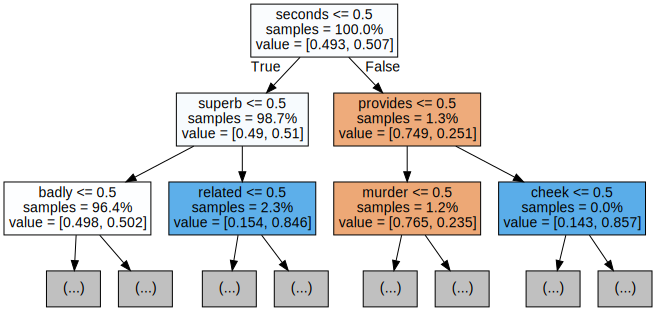

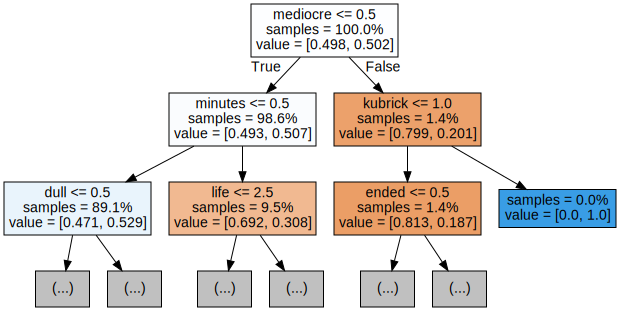

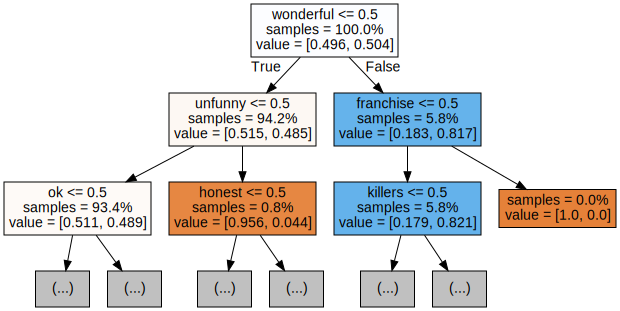

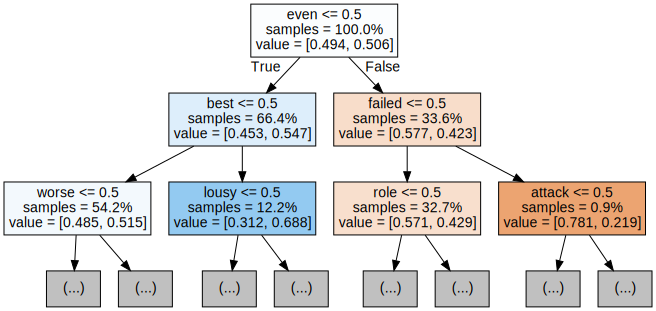

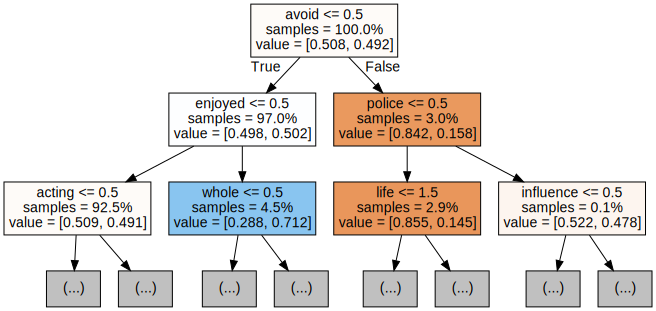

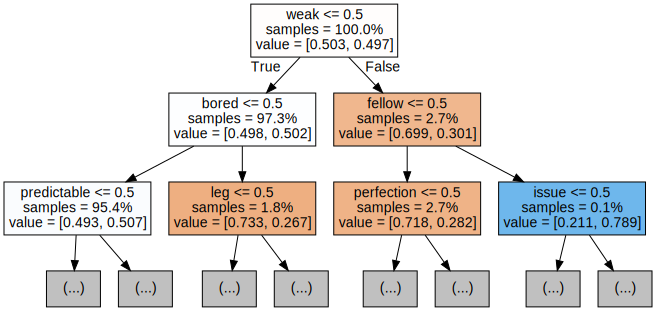

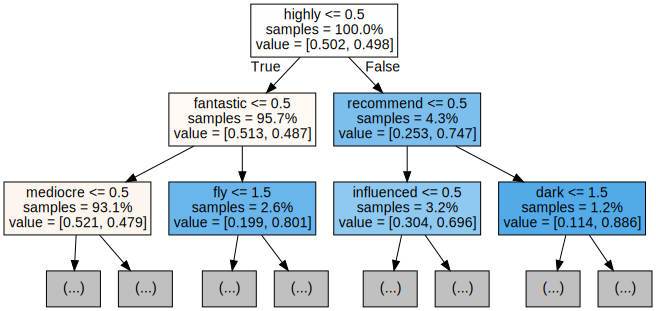

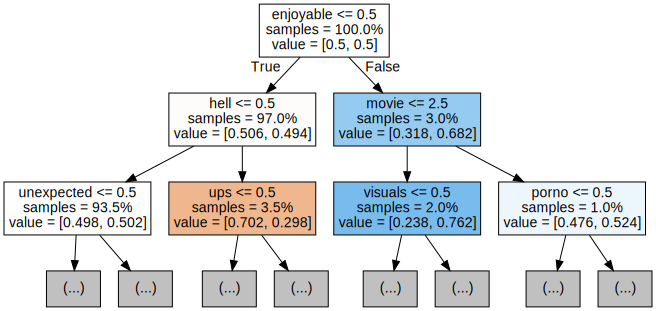

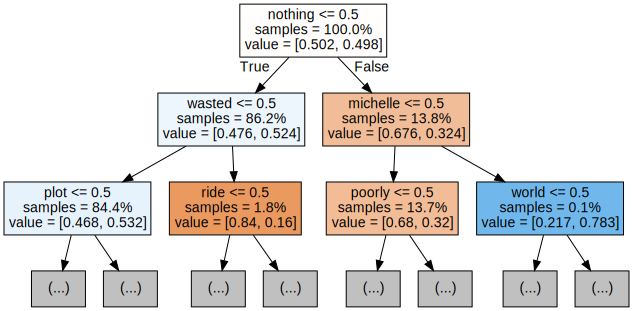

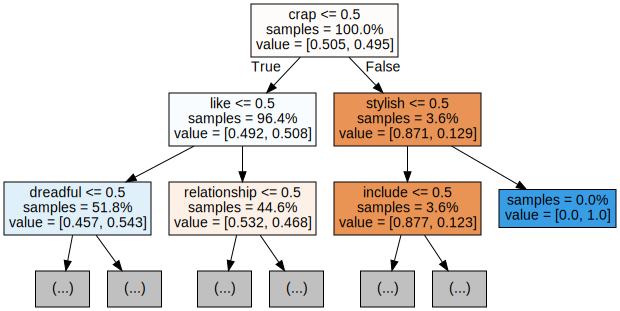

In [ ]:
 # visualize decision tree from classifier
for i in range(10):
    tree = model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=vocab,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [ ]:
print(preds_rf[0]) #first prediction for test item - model predicted positive sentiment
print(test_feat[0]) #first test review
print(clean_test_reviews[0])
print(type(y_test))
print(y_test.iloc[0])

1
[0 0 0 ... 0 0 0]
texas seven friends meet bar celebrate halloween night going party meanwhile call american nightmare pirate radio fun confess innermost fears serial killer listening confessions makes nightmares come true killing one sadistic way american nightmare weird low budget movie horrible beginning without previous explanation woman kills two couples isolated camping area friday th story shifts bar seven friends celebrating halloween moment story great potential unknown cast reasonable performance showing also beautiful breasts naked bodies usual type c production however end screenplay provide explanation killing instinct motives behavior nurse jane toppan giving sensation budget ended finalization shooting better beginning conclusion weird story would good low budget slasher movie vote four title brazil agonia agony
<class 'pandas.core.series.Series'>
0


In [ ]:
# Are bigrams better or worse features compared to Bag of Words? Make a prediction.
# https://www.pythonprogramming.in/use-sklearn-countvectorize-vocabulary-specification-with-bigrams.html
# your code here
# Is the performance better or worse?
# Why do you think that is?

# Initialize a bag of words for bigrams
bigram_vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000,
                             ngram_range=(2,2)) #vocabulary size defined here, sorted by frequency - e.g., 5k most common terms.  How does model performance change if you increase/decrease this value?

# Join the tokenized words back into strings
clean_train_bigram_reviews = [' '.join(tokens) for tokens in clean_train_bigram_reviews]
clean_test_bigram_reviews = [' '.join(tokens) for tokens in clean_test_bigram_reviews]

# Fit transform the data
train_bigram_feat = bigram_vectorizer.fit_transform(clean_train_bigram_reviews).toarray()
test_bigram_feat = bigram_vectorizer.transform(clean_test_bigram_reviews).toarray()

preds_rf_bigram, model_bigram = get_preds(test_bigram_feat, train_bigram_feat,
                  y_test, y_train,
                  RandomForestClassifier(n_estimators = 100), title='Random Forest with Bigrams')


# Is the performance better or worse?
# In my experiment, the performance with bigrams was slightly worse than with single words.

# Why do you think that is?
# Bigrams capture more context than single words, but they also lead to a much larger and sparser feature space.
# This can make it harder for the model to learn meaningful patterns, especially with a limited amount of training data.
# Additionally, some bigrams might be very infrequent and not contribute much to the prediction.


Training model, this may take some time...
Evaluating model...
Accuracy: 0.8446


# Part II: Multilayer Perceptron

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
print("Training MLP classifier... this may take some time")
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,),random_state=1, max_iter=300, verbose=True).fit(train_feat, y_train)
print("Done!")

Training MLP classifier... this may take some time
Iteration 1, loss = 0.37733727
Iteration 2, loss = 0.22472266
Iteration 3, loss = 0.18211913
Iteration 4, loss = 0.15289175
Iteration 5, loss = 0.12727419
Iteration 6, loss = 0.10200622
Iteration 7, loss = 0.08040297
Iteration 8, loss = 0.06292608
Iteration 9, loss = 0.04735772
Iteration 10, loss = 0.03409465
Iteration 11, loss = 0.02500216
Iteration 12, loss = 0.01804296
Iteration 13, loss = 0.01336113
Iteration 14, loss = 0.01071679
Iteration 15, loss = 0.00899150
Iteration 16, loss = 0.00711512
Iteration 17, loss = 0.00591232
Iteration 18, loss = 0.00505081
Iteration 19, loss = 0.00432717
Iteration 20, loss = 0.00377775
Iteration 21, loss = 0.00333354
Iteration 22, loss = 0.00294523
Iteration 23, loss = 0.00261476
Iteration 24, loss = 0.00236430
Iteration 25, loss = 0.00214439
Iteration 26, loss = 0.00195445
Iteration 27, loss = 0.00179375
Iteration 28, loss = 0.00165698
Iteration 29, loss = 0.00153799
Iteration 30, loss = 0.0014351

In [ ]:
accuracy = mlp_clf.score(test_feat, y_test)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.8596


In [ ]:
mlp_clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 300,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': True,
 'warm_start': False}

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
print("Training deeper MLP classifier... this may take some time")
mlp_clf_deeper = MLPClassifier(hidden_layer_sizes=(500,250,500,),random_state=1, max_iter=300, verbose=True).fit(train_feat, y_train)
print("Done!")

Training deeper MLP classifier... this may take some time
Iteration 1, loss = 0.35325387
Iteration 2, loss = 0.12929845
Iteration 3, loss = 0.02355915
Iteration 4, loss = 0.01037890
Iteration 5, loss = 0.00514010
Iteration 6, loss = 0.01402658
Iteration 7, loss = 0.01379814
Iteration 8, loss = 0.00423887
Iteration 9, loss = 0.00307287
Iteration 10, loss = 0.00326334
Iteration 11, loss = 0.00410078
Iteration 12, loss = 0.00643897
Iteration 13, loss = 0.00581642
Iteration 14, loss = 0.00281204
Iteration 15, loss = 0.00156688
Iteration 16, loss = 0.00094355
Iteration 17, loss = 0.00085775
Iteration 18, loss = 0.00084179
Iteration 19, loss = 0.00083649
Iteration 20, loss = 0.00083202
Iteration 21, loss = 0.00082792
Iteration 22, loss = 0.00082404
Iteration 23, loss = 0.00082025
Iteration 24, loss = 0.00081652
Iteration 25, loss = 0.00081280
Iteration 26, loss = 0.00080906
Iteration 27, loss = 0.00080530
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stoppin

In [ ]:
accuracy = mlp_clf_deeper.score(test_feat, y_test)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.865


In [ ]:
# Bias Variance tradeoff in ML theory holds that system error is a combination of bias, variance, and irreducible error
# According to this theory, reducing bias increase variance, which can lead to poor generalization.
# On the other hand, reducing variance increases bias, which can lead to poor model fit to training data.
# A number of techniques are used to balance bias and variance, including increasing/decreasing number of parameters, randomly ignoring parts of the parameter space during training, and others.


##AFTER TUNING

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    activation='logistic',  # Sigmoid activation function
    alpha=0.0005,          # L2 regularization parameter
    hidden_layer_sizes=(300,),  # Single hidden layer with 300 neurons
    learning_rate='adaptive',  # Adaptive learning rate
    learning_rate_init=0.0005,  # Initial learning rate
    solver='adam',  # Adam solver
    beta_1=0.9,  # Adam beta1 parameter
    beta_2=0.999,  # Adam beta2 parameter
    epsilon=1e-08,  # Adam epsilon parameter
    max_iter=500,  # Maximum number of iterations
    early_stopping=True,  # Enable early stopping
    validation_fraction=0.1,  # Fraction of training data used for validation
    n_iter_no_change=10,  # Number of iterations without improvement before early stopping
    random_state=1,    # Random state for reproducibility
    verbose=True  # Enable verbose output
)

# Fit the model on the training data
mlp.fit(train_feat, y_train)

# Evaluate the model on the test set
accuracy = mlp.score(test_feat, y_test)
print("Revised MLP model accuracy on test set: {:.4f}".format(accuracy))


Iteration 1, loss = 0.53188072
Validation score: 0.856500
Iteration 2, loss = 0.33881505
Validation score: 0.871000
Iteration 3, loss = 0.26384345
Validation score: 0.879000
Iteration 4, loss = 0.22654742
Validation score: 0.881000
Iteration 5, loss = 0.20229838
Validation score: 0.877500
Iteration 6, loss = 0.18509563
Validation score: 0.873500
Iteration 7, loss = 0.17076163
Validation score: 0.877000
Iteration 8, loss = 0.16015215
Validation score: 0.875500
Iteration 9, loss = 0.15097017
Validation score: 0.871500
Iteration 10, loss = 0.14320824
Validation score: 0.869500
Iteration 11, loss = 0.13597346
Validation score: 0.869000
Iteration 12, loss = 0.12972504
Validation score: 0.862500
Iteration 13, loss = 0.12411530
Validation score: 0.865500
Iteration 14, loss = 0.11946782
Validation score: 0.862000
Iteration 15, loss = 0.11474231
Validation score: 0.857500
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Revised MLP model accuracy on t

In [ ]:
mlp.get_params()

{'activation': 'logistic',
 'alpha': 0.0005,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': True,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (300,),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.0005,
 'max_fun': 15000,
 'max_iter': 500,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': True,
 'warm_start': False}